In [56]:
import os
import json
import re

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import tifffile
import skimage
from skimage.io import imread, imsave

In [2]:
# !pip install scikit-image==0.18.1

In [3]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [4]:
# !pip install git+https://github.com/estorrs/mgitools
import mgitools.os_helpers as os_helpers

In [5]:
img_fps = sorted(os_helpers.listfiles('../data/histology_classification/vasculature_endothelia/imgs/'))
img_fps

['../data/histology_classification/vasculature_endothelia/imgs/RESL10B1_1MONTH_F12468L_TILE_20X_ch00.jpg',
 '../data/histology_classification/vasculature_endothelia/imgs/RESL10B1_2MONTH_F12465L_TILE_20X_ch00.jpg',
 '../data/histology_classification/vasculature_endothelia/imgs/RESL10B1_2MONTH_F12467L_TILE_20X_ch00.jpg',
 '../data/histology_classification/vasculature_endothelia/imgs/RESL5E_2MONTH_14529_TILE_20X_ch00.jpg',
 '../data/histology_classification/vasculature_endothelia/imgs/RESL5E_2MONTH_14529_TILE_20X_ch00.tif']

In [6]:
annotations = json.load(open('../data/histology_classification/vasculature_endothelia/PDX_Annotations_Vasculature.json'))
annotations

{'RESL5E_2MONTH_14529_TILE_20X_ch00.jpg': {'fileref': '',
  'size': 70295398,
  'filename': 'RESL5E_2MONTH_14529_TILE_20X_ch00.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {'0': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [5372.576890287884,
      5261.579447832642,
      5114.507836579444,
      5036.809626860774,
      5108.957964456682,
      5206.08072660502,
      5383.676634533408,
      5450.275100006554,
      5444.725227883792,
      5372.576890287884],
     'all_points_y': [6548.849104859331,
      6537.749360613807,
      6693.145780051147,
      6773.618925831198,
      6862.416879795393,
      6854.092071611249,
      6762.519181585673,
      6690.3708439897655,
      6623.77237851662,
      6548.849104859331]},
    'region_attributes': {'label': 'Vasculature Endothelia'}},
   '1': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [4928.587120466913,
      4812.039805888908,
      4817.58967801167,
      4953.5615450193

In [7]:
{r['region_attributes']['label'] for k, v in annotations.items() for i, r in v['regions'].items()}

{'Vasculature Endothelia'}

In [8]:
label = 'Vasculature Endothelia'

In [9]:
annotations.keys()

dict_keys(['RESL5E_2MONTH_14529_TILE_20X_ch00.jpg', 'RESL10B1_2MONTH_F12467L_TILE_20X_ch00.jpg', 'RESL5E_1MONTH_14531_TILE_20X.jpg', 'RESL10B1_1MONTH_F12468L_TILE_20X_ch00.jpg', 'RESL10B1_2MONTH_F12465L_TILE_20X_ch00.jpg'])

In [64]:
d = {}
for fp in img_fps:
    identifier = fp.split('/')[-1]
    if identifier in annotations:
        regions = {k:r for k, r in annotations[identifier]['regions'].items()
                   if r['region_attributes']['label']==label}
        d[identifier] = {'filepath': fp, 'regions': regions}
d.keys()
            

dict_keys(['RESL10B1_1MONTH_F12468L_TILE_20X_ch00.jpg', 'RESL10B1_2MONTH_F12465L_TILE_20X_ch00.jpg', 'RESL10B1_2MONTH_F12467L_TILE_20X_ch00.jpg', 'RESL5E_2MONTH_14529_TILE_20X_ch00.jpg'])

In [65]:
# img = imread('../data/histology_classification/vasculature_endothelia/imgs/RESL10B1_1MONTH_F12468L_TILE_20X_ch00.jpg')
# img.shape

In [66]:
from skimage import draw
from skimage.segmentation import expand_labels
import numpy as np

In [67]:
annotation_dict = {}
for identifier, info in d.items():
    print(identifier)
    img = imread(info['filepath'])
    ann_mask = np.zeros((img.shape[0], img.shape[1]))
    for rid, m in info['regions'].items():
#         print(m.keys())
        rs = [int(x) for x in m['shape_attributes']['all_points_y']]
        cs = [int(x) for x in m['shape_attributes']['all_points_x']]
        rr, cc = draw.polygon(rs, cs)
        ann_mask[rr, cc] = int(rid)
        
    expanded = expand_labels(ann_mask, distance=10)
    border = np.logical_and(ann_mask<1, expanded>0)
    
    clf_mask = ann_mask.copy()
    clf_mask[clf_mask>0] = 1
    clf_mask[border] = 2
    clf_mask[clf_mask==0] = 3
        
    annotation_dict[identifier] = {'he': img, 'mask': ann_mask, 'clf_mask':clf_mask.astype(np.uint8)}
        

RESL10B1_1MONTH_F12468L_TILE_20X_ch00.jpg
RESL10B1_2MONTH_F12465L_TILE_20X_ch00.jpg
RESL10B1_2MONTH_F12467L_TILE_20X_ch00.jpg
RESL5E_2MONTH_14529_TILE_20X_ch00.jpg


RESL10B1_1MONTH_F12468L_TILE_20X_ch00.jpg


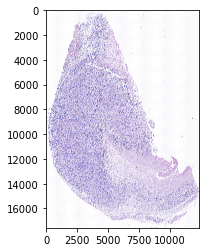

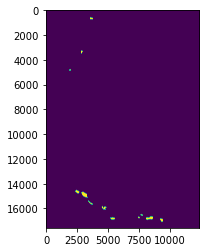

RESL10B1_2MONTH_F12465L_TILE_20X_ch00.jpg


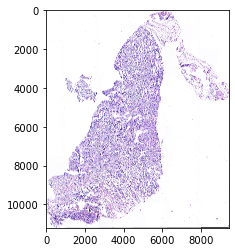

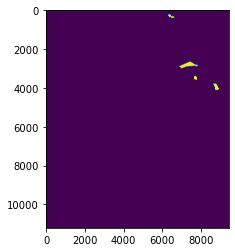

RESL10B1_2MONTH_F12467L_TILE_20X_ch00.jpg


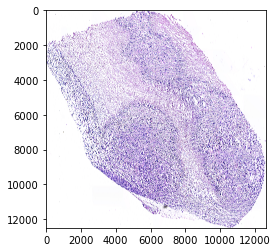

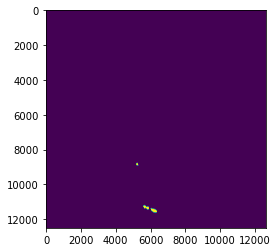

RESL5E_2MONTH_14529_TILE_20X_ch00.jpg


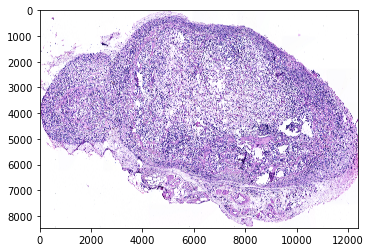

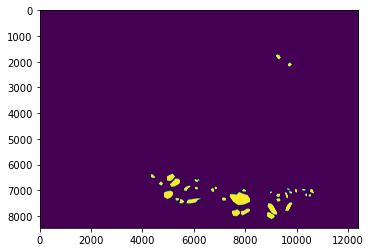

In [44]:
import matplotlib.pyplot as plt
for k, d in annotation_dict.items():
    print(k)
    plt.imshow(d['he'])
    plt.show()
    plt.imshow(d['mask'])
    plt.show() 


In [72]:
n = 448
he_dir = '../data/histology_classification/vasculature_endothelia/extracted/he'
mask_dir = '../data/histology_classification/vasculature_endothelia/extracted/mask'
from pathlib import Path
Path(he_dir).mkdir(exist_ok=True, parents=True)
Path(mask_dir).mkdir(exist_ok=True, parents=True)
count = 1
for k, d in annotation_dict.items():
    im_id = k.split('.')[0]
    for r in range(0, d['he'].shape[0], n):
        for c in range(0, d['he'].shape[1], n):
            clf_mask = d['clf_mask'][r:r+n, c:c+n]
#             print(clf_mask.shape)
    
            if clf_mask.shape[0]==n and clf_mask.shape[1]==n and np.count_nonzero(clf_mask==1):
                he = d['he'][r:r+n, c:c+n]
                imsave(os.path.join(he_dir, f'{im_id}-{count}.jpg'), he)
                imsave(os.path.join(mask_dir, f'{im_id}-{count}.jpg'), clf_mask)
                count+=1

/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_1MONTH_F12468L_TILE_20X_ch00-1.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_1MONTH_F12468L_TILE_20X_ch00-2.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_1MONTH_F12468L_TILE_20X_ch00-3.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_1MONTH_F12468L_TILE_20X_ch00-4.jpg is a low contrast image
/Users/e

/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_2MONTH_F12467L_TILE_20X_ch00-34.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_2MONTH_F12467L_TILE_20X_ch00-35.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_2MONTH_F12467L_TILE_20X_ch00-36.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL10B1_2MONTH_F12467L_TILE_20X_ch00-37.jpg is a low contrast image
/Use

/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL5E_2MONTH_14529_TILE_20X_ch00-74.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL5E_2MONTH_14529_TILE_20X_ch00-75.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL5E_2MONTH_14529_TILE_20X_ch00-76.jpg is a low contrast image
/Users/erikstorrs/miniconda3/envs/spatial/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: ../data/histology_classification/vasculature_endothelia/extracted/mask/RESL5E_2MONTH_14529_TILE_20X_ch00-77.jpg is a low contrast image
